# Instacart Market Basket Analysis

Instacart에서 제공하는 dataset은 익명화된 20만 이상의 유저로부터 340만 이상의 주문이 포함되어 있습니다.

목표:
타겟은 어떤 제품이 유저의 다음 구매에 들어갈지 예측하는 것 입니다.


# 1. 데이터 살펴보기



제공되는 데이터셋은 총 7개의 csv파일로 이루어져 있습니다.

1. orders.csv (3421083, 7) <br/>
unique한 주문 id에 별로 정보가 있습니다.

    <img src=https://user-images.githubusercontent.com/89520805/167748653-3dd79f32-443f-49b1-a293-e2ec36f4849f.png width=700 height=150>

2. order_products__priors.csv (32434489, 4) <br/>
고객별로 마지막 주문을 제외한 모든 주문에 대한 구매내역입니다.
각 행의 order_id와 product_id를 하나의 조합이라고 볼 수 있습니다.

    <img src=https://user-images.githubusercontent.com/89520805/167748919-dc42cbe8-eb55-44b0-b4c5-0f088c1a19b3.png width=400 height=150>

3. order_products__train.csv (1384617, 4) <br/>
일부 고객의 마지막 주문 구매내역 입니다.구매예측을 위해서 해당 데이터를 가지고 타겟을 생성해야 합니다.

    <img src=https://user-images.githubusercontent.com/89520805/167749067-652a45e7-658c-4a28-ac6c-e08fd601afe0.png width=400 height=150>

4. products.csv (49688, 4)<br/>
등록된 제품 id를 기준으로 제품에 대한 4개 정보가 들어있습니다.

    <img src=https://user-images.githubusercontent.com/89520805/167749255-52f05c2e-fa84-472b-9195-eca80b5eb3f1.png width=600 height=150>

5. aisles.csv (134, 2) <br/>
제품을 소 분류로 분류한 정보입니다.

    <img src=https://user-images.githubusercontent.com/89520805/167749643-b11ce7b9-e765-4f42-9da3-33491b014172.png width=280 height=150>

6. departments.csv (21, 2)<br/>
제품을 대 분류로 분류한 정보입니다.

    <img src=https://user-images.githubusercontent.com/89520805/167749715-9a5717d3-6739-4a3f-9a79-9067a1326ada.png width=250 height=150>

7. sample_submission.csv (75000, 2)<br/>
제출해야하는 형식 파일입니다. orders['eval_set'] == test 인 order_id이다.

    <img src=https://user-images.githubusercontent.com/89520805/167749883-9b0caa6b-24a0-4396-bca8-e0d6a6e3b270.png width=190 height=150>

# Issues 

1. 메모리 관리

    - 피쳐별 데이터 타입 변환 함수 사용
    - 사용하지 않는 변수는 삭제

2. 피쳐 생성

    - 먼저 groupby가 가능한 피쳐들을 생성. 이후에 판단 필요

3. 데이터 재가공

    - 대회 목적에 맞는 예측을 하기 위한 훈련이 가능한 형태로 데이터를 재가공


- 참고 코드

    - https://www.kaggle.com/code/sudalairajkumar/simple-exploration-notebook-instacart
    - https://www.kaggle.com/code/paulantoine/light-gbm-benchmark-0-3692



# 데이터 로드

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

PATH = '/content/drive/MyDrive/data/instacart-market-basket-analysis/' # csv파일이 들어있는 폴더 경로 지정

In [ ]:
priors = pd.read_csv(PATH + 'order_products__prior.csv', dtype={
            'order_id': np.uint32,          # 1 ~ 3421083
            'product_id': np.uint16,        # 1 ~ 49688
            'add_to_cart_order': np.uint8,  # 1 ~ 80 
            'reordered': np.uint8})         # 0 ~ 1
orders = pd.read_csv(PATH + 'orders.csv', dtype={
        'order_id': np.uint32,              # 1 ~ 3421083
        'user_id': np.uint32,               # 1 ~ 206209
        'eval_set': 'category',             # 3가지
        'order_number': np.uint8,           # 1 ~ 100
        'order_dow': np.uint8,              # 0 ~ 6 
        'order_hour_of_day': np.uint8,      # 0 ~ 23
        'days_since_prior_order': np.float32})
products = pd.read_csv(PATH + 'products.csv', dtype={
        'product_id': np.uint16,     # 1 ~ 49688
        'aisle_id': np.uint8,        # 1 ~ 134
        'department_id': np.uint8}) # 1 ~ 21

### 데이터 타입 downcast함수

<img src = https://user-images.githubusercontent.com/89520805/166191804-c083cbd2-5f3f-4850-8f4f-41fc8982a090.png height = 450 width = 500>

In [ ]:
## 데이터 크기 확인 함수
def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

## 이산형 데이터 사이즈 축소 함소
def int_memory_reduce(data) :
    data_int = data.select_dtypes(include=['int'])
    converted_int = data_int.apply(pd.to_numeric,downcast='unsigned')
    print(f"Before : {mem_usage(data_int)} -> After : {mem_usage(converted_int)}")
    data[converted_int.columns] = converted_int
    return data

## 연속형 데이터 사이즈 축소 함소
def float_memory_reduce(data) :
    data_float = data.select_dtypes(include=['float'])
    converted_float = data_float.apply(pd.to_numeric,downcast='float')
    print(f"Before : {mem_usage(data_float)} -> After : {mem_usage(converted_float)}")
    data[converted_float.columns] = converted_float
    return data

## 문자형 데이터 사이즈 축소 함소
def object_memory_reduce(data) :
    gl_obj = data.select_dtypes(include=['object']).copy()
    converted_obj = pd.DataFrame()
    for col in gl_obj.columns:
        num_unique_values = len(gl_obj[col].unique())
        num_total_values = len(gl_obj[col])
        if num_unique_values / num_total_values < 0.5:
            converted_obj.loc[:,col] = gl_obj[col].astype('category')
        else:
            converted_obj.loc[:,col] = gl_obj[col]
    print(f"Before : {mem_usage(gl_obj)} -> After : {mem_usage(converted_obj)}")
    data[converted_obj.columns] = converted_obj
    return data

def memory_reduce(data, except_col=None) :
    print(f"Before : {mem_usage(data)}")
    if except_col:
        col = data[except_col]
        data.drop(except_col, axis=1, inplace=True)

    data_int = data.select_dtypes(include=['int'])
    data_float = data.select_dtypes(include=['float'])
    gl_obj = data.select_dtypes(include=['object']).copy()

    converted_int = data_int.apply(pd.to_numeric,downcast='unsigned')
    converted_float = data_float.apply(pd.to_numeric,downcast='float')
    converted_obj = pd.DataFrame()
    for col in gl_obj.columns:
        num_unique_values = len(gl_obj[col].unique())
        num_total_values = len(gl_obj[col])
        if num_unique_values / num_total_values < 0.5:
            converted_obj.loc[:,col] = gl_obj[col].astype('category')
        else:
            converted_obj.loc[:,col] = gl_obj[col]
    
    print(f"정수형 데이터 Before : {mem_usage(data_int)} -> After : {mem_usage(converted_int)}")
    print(f"실수형 데이터 Before : {mem_usage(data_float)} -> After : {mem_usage(converted_float)}")
    print(f"문자열 데이터 Before : {mem_usage(gl_obj)} -> After : {mem_usage(converted_obj)}")
    
    data[converted_int.columns] = converted_int
    data[converted_float.columns] = converted_float
    data[converted_obj.columns] = converted_obj

    if except_col:
        data = pd.concat([data, col], axis=1)

    print(f"After : {mem_usage(data)}\n")

    return data

In [ ]:
priors[priors['order_id'] == 2539329]

,order_id,product_id,add_to_cart_order,reordered
24076664,2539329,196,1,0
24076665,2539329,14084,2,0
24076666,2539329,12427,3,0
24076667,2539329,26088,4,0
24076668,2539329,26405,5,0


In [ ]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


# 1. Orders

모든 주문 정보를 확인할 수 있다.

총 3,421,083개의 row가 있다. 이 데이터의 모든 주문 수

- order_id : 주문 번호, (범주형, 명목형)

    총 3,421,083개의 주문이 있다.

- user_id : 고객 번호, (범주형, 명목형)

    총 206,209명의 데이터

- eval_set : 데이터 구분, (범주형, 명목형)

    prior, train, test로 구분. 

    - prior : 고객별 마지막 주문을 제외한 모든 주문

    - train : 131,209명의 마지막 주문. 주문별 구매 내역이 있다.

    - test : 75,000명의 마지막 주문. 주문별 구매 내역을 예측해야 한다.

- order_number : 해당 고객의 몇 번째 주문인지, (범주형, 순서형)

    최소 주문 수는 4건, 최대 주문 수는 100건이다. 

- order_dow : 주문 요일 (범주형, 명목형)

- order_hour_of_day : 주문 시간 (범주형, 명목형)

- days_since_prior_order : 이전 주문과의 간격 (일). 최대 30일이다. (범주형, 명목형)

In [ ]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


## 결측치 확인

In [ ]:
orders.isna().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

days_since_prior_order에 206,209 건의 결측치가 있다. 첫번째 주문은 이전 주문이 없기 때문에 모든 고객의 수만큼 결측치가 있다.

0으로 결측치를 채워준다.

In [ ]:
orders.days_since_prior_order.fillna(0, inplace=True)
orders.isna().sum()

order_id                  0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
dtype: int64

## order_id

주문 번호

In [ ]:
print(f"총 주문 수 : {orders.order_id.nunique()}")

총 주문 수 : 3421083


## user_id

고객 번호

In [ ]:
print(f"총 고객 수 : {orders.user_id.nunique()}")

총 고객 수 : 206209


## eval_set

데이터 구분

prior, train, test로 구분.

- prior : 고객별 마지막 주문을 제외한 모든 주문

- train : 131,209명의 마지막 주문. 주문별 구매 내역이 있다.

- test : 75,000명의 마지막 주문. 주문별 구매 내역을 예측해야 한다.

prior    3214874
train     131209
test       75000
Name: eval_set, dtype: int64


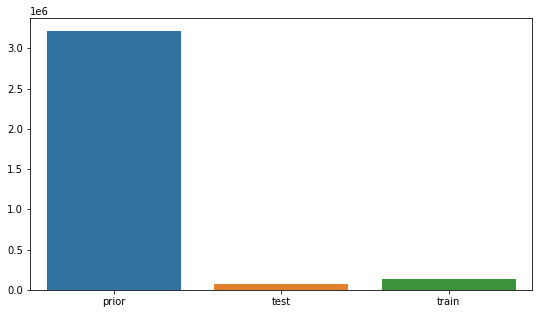

In [ ]:
data = orders.eval_set.value_counts()
print(data)
plt.figure(figsize=(9, 5))
sns.barplot(x=data.index, y=data.values)
plt.show()

## order_number

해당 고객의 몇 번째 주문인지 알 수 있다. 

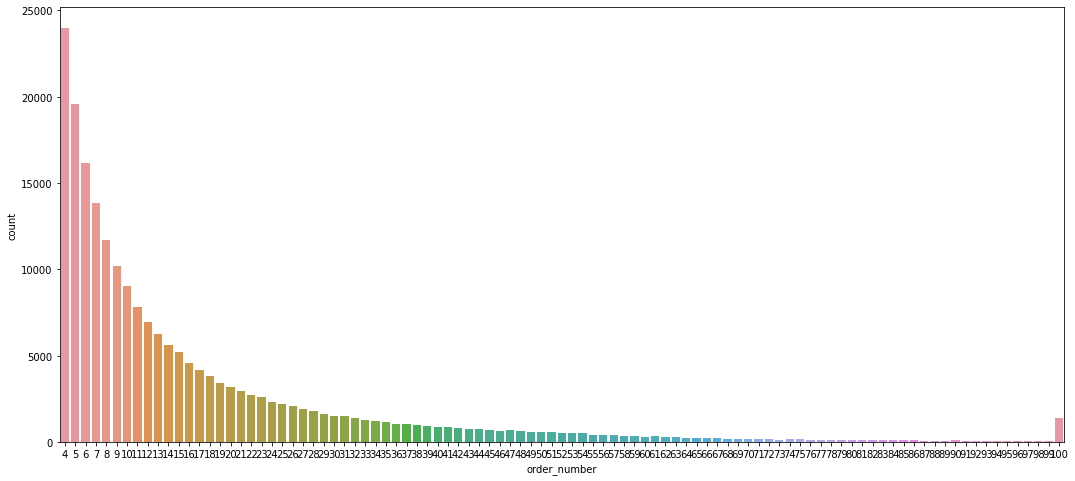

In [ ]:
plt.figure(figsize=(18, 8))
data = orders.groupby('user_id')['order_number'].max().reset_index()
sns.countplot(x='order_number', data=data)
plt.show()

In [ ]:
orders.groupby('user_id')['order_number'].max().describe()

count    206209.000000
mean         16.590367
std          16.654774
min           4.000000
25%           6.000000
50%          10.000000
75%          20.000000
max         100.000000
Name: order_number, dtype: float64

최소 주문 수는 4건, 최대 주문 수는 100건이다. 고객 평균 주문 수는 16건, 중앙값은 10이다.

4회 주문한 고객이 가장 많다.

## order_dow

주문 요일

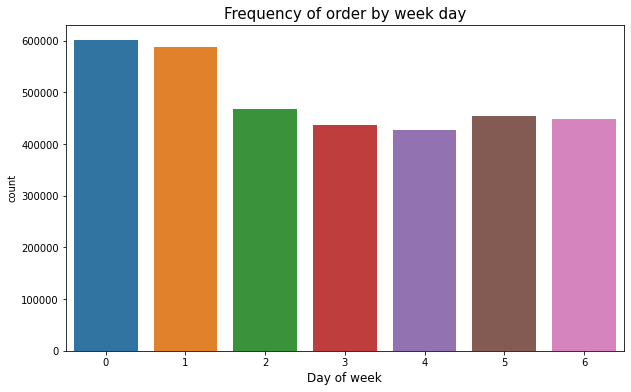

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='order_dow', data=orders)
plt.title("Frequency of order by week day", fontsize=15)
plt.xlabel('Day of week', fontsize=12)
plt.show()

In [ ]:
round(orders.order_dow.value_counts()[:2].mean() / orders.order_dow.value_counts()[2:].mean(), 2)

1.33

0은 토요일, 1은 일요일이다. 주말이 평일에 비해서 주문 수가 약 33%가 많다.

## order_hour_of_day

주문 시간

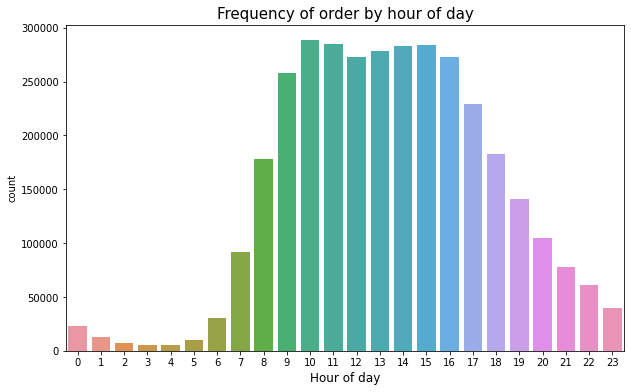

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='order_hour_of_day', data=orders)
plt.title("Frequency of order by hour of day", fontsize=15)
plt.xlabel('Hour of day', fontsize=12)
plt.show()

대부분의 고객들은 9~17시 사이에 주문하는 것을 볼 수 있다.


### 요일 x 시간

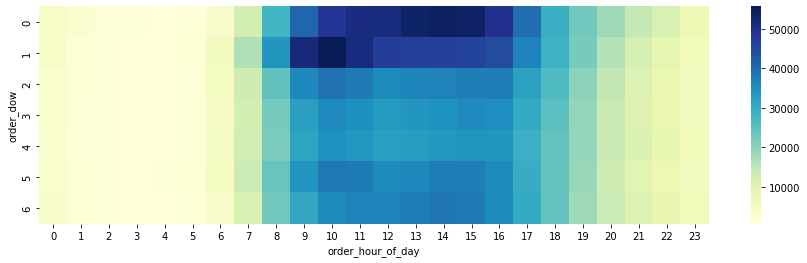

In [ ]:
plt.figure(figsize=(15, 4))
data = orders.groupby(['order_dow', 'order_hour_of_day'])['order_number'].count().reset_index().pivot('order_dow','order_hour_of_day','order_number')
sns.heatmap(data, cmap="YlGnBu")
plt.show()

평일에 비하면 주말이 확연히 주문량이 많은 것을 볼 수 있다. 토요일은 오후, 일요일은 오전에 주문이 가장 많은 것을 확인할 수 있다.
토요일은 모든 요일 중에서 가장 늦은 시간까지 주문이 일어난다. 
평일을 보면 화요일과 수요일이 비교적 주문이 적은 것을 볼 수 있다.


## days_since_prior_order

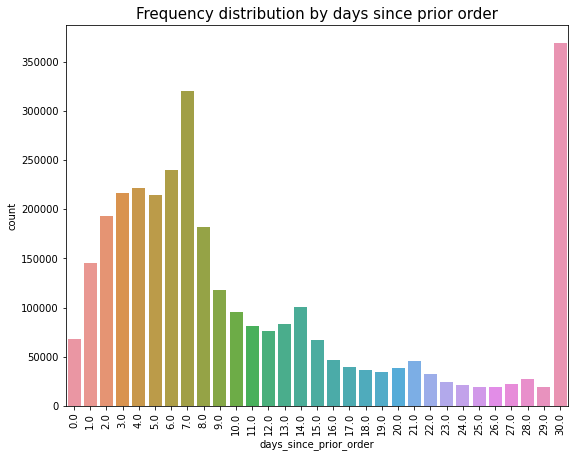

In [ ]:
plt.figure(figsize=(9,7))
sns.countplot(x='days_since_prior_order', data=orders)
plt.xticks(rotation='vertical')
plt.title("Frequency distribution by days since prior order", fontsize=15)
plt.show()

주문 간격이 30일 이상인 케이스가 가장 많고, 대체로 1~8일 간격인 케이스가 많으며 7일 주기(7, 14, 21, 28)로 주문하는 고객도 보인다.

# 2. priors

마지막 주문을 제외한 모든 주문 별로 구매 내역을 확인할 수 있다. 

총 row 수는 32,434,489개다. 이 데이터에서 총 판매된 제품의 수다.

- order_id : 주문 번호 (범주형, 명목형)

- product_id : 제품 번호 (범주형, 명목형)

    총 49,677 종의 제품이 있다. (총 팔린 제품이다.)

- add_to_cart_order : 제품이 장바구니에 담긴 순서 (범주형, 순서형)

- reordered : 재구매 여부 (범주형, 명목형)

In [ ]:
priors.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


## 제품 정보 추가

제품에 aisle정보와 department정보를 추가한다.

그리고 priors에 추가한다. 제품명과 대분류, 소분류 명을 넣는다.

In [ ]:
aisles = pd.read_csv(PATH + 'aisles.csv', dtype={
    'aisle_id' : np.uint8
})
departments = pd.read_csv(PATH + 'departments.csv', dtype={
    'department_id' : np.uint8
})

products = pd.merge(products, aisles)
products = pd.merge(products, departments).sort_values('product_id').reset_index(drop=True)
products = products[['product_id', 'product_name', 'aisle_id', 'aisle', 'department_id', 'department']]
priors = pd.merge(priors, products).sort_values('order_id').reset_index(drop=True)
memory_reduce(priors).info() # 7070.78 MB -> 527.2 MB

Before : 7070.78 MB
정수형 데이터 Before : 0.00 MB -> After : 0.00 MB
실수형 데이터 Before : 0.00 MB -> After : 0.00 MB
문자열 데이터 Before : 6764.95 MB -> After : 221.73 MB
After : 531.05 MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 9 columns):
 #   Column             Dtype   
---  ------             -----   
 0   order_id           uint32  
 1   product_id         uint16  
 2   add_to_cart_order  uint8   
 3   reordered          uint8   
 4   product_name       category
 5   aisle_id           uint8   
 6   aisle              category
 7   department_id      uint8   
 8   department         category
dtypes: category(3), uint16(1), uint32(1), uint8(4)
memory usage: 527.2 MB


In [ ]:
priors.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,aisle,department_id,department
0,2,33120,1,1,Organic Egg Whites,86,eggs,16,dairy eggs
1,2,45918,4,1,Coconut Butter,19,oils vinegars,13,pantry
2,2,30035,5,0,Natural Sweetener,17,baking ingredients,13,pantry
3,2,17794,6,1,Carrots,83,fresh vegetables,4,produce
4,2,9327,3,0,Garlic Powder,104,spices seasonings,13,pantry


## 주문 정보

### 주문 당 구매 제품 수

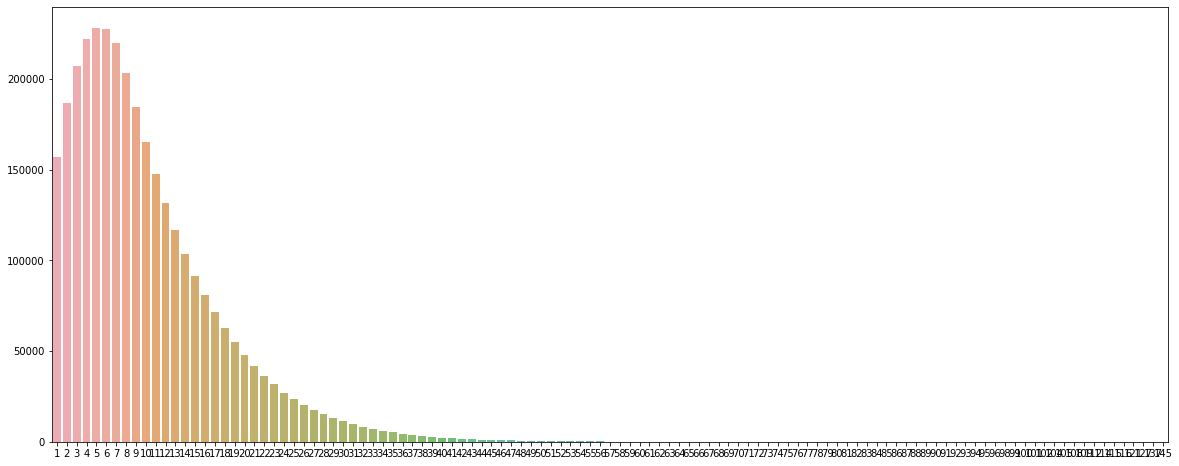

In [ ]:
data = priors.groupby('order_id')['add_to_cart_order'].max()
plt.figure(figsize=(20,8))
sns.barplot(data.index, data.values, alpha=0.8)
plt.show()

In [ ]:
data.describe().astype(np.uint32)

count    3214874
mean          10
std            7
min            1
25%            5
50%            8
75%           14
max          145
Name: add_to_cart_order, dtype: uint32

주문 당 구매 제품 수는 평균 10개다. 

### 주문 별 재주문 제품 포함 비율


In [ ]:
(priors.groupby('order_id')['reordered'].sum() >= 1).astype(np.uint8).value_counts() / priors.order_id.nunique()

1    0.879151
0    0.120849
Name: reordered, dtype: float64

In [ ]:
# 모든 첫 주문을 뺀 주문 별 재주문 제품 포함 비율 (모든 첫 주문은 재주문 제품이 포함되지 않기 때문)
order_ids = orders[(orders['order_number'] != 1) & (orders['eval_set'] == 'prior')].order_id

(priors[priors.order_id.isin(order_ids)].groupby('order_id')['reordered'].sum() >= 1).astype(np.uint8).value_counts() / \
order_ids.nunique()

1    0.939407
0    0.060593
Name: reordered, dtype: float64

전체 order 중 12%는 구매했던 이력이 없는 제품을 구매한 주문이다. 대부분의 고객은 이전에 주문했던 제품을 다시 구매 하는 것으로 보인다.

(주문 별로 재주문 제품 포함 여부를 피쳐로 만들어서 추가할 수 있다.) 

## reordered

### 재구매 여부

In [ ]:
print(f"총 판매 제품 수 : {priors.shape[0]}")
print(f"재구매 제품 수 : {priors.reordered.sum()}")
print(f"재구매 제품 비율 : {(priors.reordered.sum() / priors.shape[0]) * 100:.1f}%")

총 판매 제품 수 : 32434489
재구매 제품 수 : 19126536
재구매 제품 비율 : 59.0%


판매된 모든 제품 중 59%의 제품이 재주문된 제품이다.

## add_to_cart_order

### 장바구니에 담긴 순서 별 재구매 율

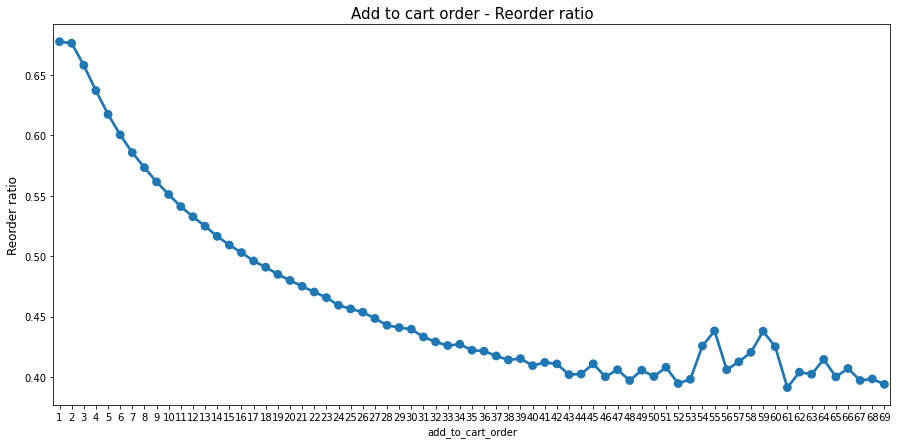

In [ ]:
data = priors[priors['add_to_cart_order'] < 70].groupby('add_to_cart_order')['reordered'].mean()

plt.figure(figsize=(15, 7))
sns.pointplot(data.index, data.values)
plt.title("Add to cart order - Reorder ratio", fontsize=15)
plt.ylabel('Reorder ratio', fontsize=12)
plt.show()

유저가 장바구니에 담은 순서에 따라 재구매율이 큰 영향을 받는 것을 확인할 수 있다. 다시 구매할 제품을 먼저 장바구니에 담는 것으로 보인다.

# 3. Products




총 49,688개의 row가 있다. 데이터에서 취급하는 모든 제품이다.

priors 데이터를 보면 1개라도 팔린 제품은 49,677개다. 11개의 제품은 팔린 적이 없다.

팔린 적이 없는 데이터는 제거하고 진행한다.

제품별로 피쳐를 생성한다.

1. orders : 총 팔린 수
2. reorders : 재주문 수
3. reorder_rate : 재주문 율
4. mean_cart_order : 평균 장바구니 순위

In [ ]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  uint16
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  uint8 
 3   aisle          49688 non-null  object
 4   department_id  49688 non-null  uint8 
 5   department     49688 non-null  object
dtypes: object(3), uint16(1), uint8(2)
memory usage: 1.3+ MB


## ✅ 제품 정보 추가

## 제품별 총 팔린 수, 재주문 수, 재주문 율 생성

In [ ]:
prods = pd.DataFrame()
# 총 팔린 수
prods['orders'] = priors.product_id.value_counts().sort_index()
# 재주문 수
prods['reorders'] = priors.groupby('product_id')['reordered'].sum()
# 재주문 율
prods['reorder_rate'] = (prods.reorders / prods.orders)
# 평균 장바구니 순위
prods['mean_cart_order'] = priors.groupby('product_id')['add_to_cart_order'].mean()
prods = prods.reset_index().rename(columns={'index':'product_id'})
int_memory_reduce(prods).head()

Before : 0.38 MB -> After : 0.19 MB


,product_id,orders,reorders,reorder_rate,mean_cart_order
0,1,1852,1136.0,0.613391,5.801836
1,2,90,12.0,0.133333,9.888889
2,3,277,203.0,0.732852,6.415162
3,4,329,147.0,0.446809,9.507599
4,5,15,9.0,0.600000,6.466667


In [ ]:
products.shape, prods.shape

((49688, 6), (49677, 5))

총 49688개의 제품 중에서 11개의 제품은 팔린 적이 없다. 

생성한 feature를 products에 추가한다. 

In [ ]:
products = pd.merge(products, prods) 
# Default는 inner병합이어서 팔린 적 없는 11개의 제품은 제외된다. 만약 결측치로 두고 싶다면 how='outer'로 설정하면 행은 그대로 남고 결측치로 채워진다.
del prods
int_memory_reduce(products)

Before : 0.38 MB -> After : 0.38 MB


,product_id,product_name,aisle_id,department_id,orders,reorders,reorder_rate,mean_cart_order
0,1,Chocolate Sandwich Cookies,61,19,1852,1136.0,0.613391,5.801836
1,2,All-Seasons Salt,104,13,90,12.0,0.133333,9.888889
2,3,Robust Golden Unsweetened Oolong Tea,94,7,277,203.0,0.732852,6.415162
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1,329,147.0,0.446809,9.507599
4,5,Green Chile Anytime Sauce,5,13,15,9.0,0.600000,6.466667
...,...,...,...,...,...,...,...,...
49672,49684,"Vodka, Triple Distilled, Twist of Vanilla",124,5,9,1.0,0.111111,4.333333
49673,49685,En Croute Roast Hazelnut Cranberry,42,1,49,6.0,0.122449,9.571429
49674,49686,Artisan Baguette,112,3,120,84.0,0.700000,7.500000
49675,49687,Smartblend Healthy Metabolism Dry Cat Food,41,8,13,6.0,0.461538,7.538462


In [ ]:
products.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49677 entries, 0 to 49676
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   product_id     49677 non-null  uint16 
 1   product_name   49677 non-null  object 
 2   aisle_id       49677 non-null  uint8  
 3   aisle          49677 non-null  object 
 4   department_id  49677 non-null  uint8  
 5   department     49677 non-null  object 
 6   orders         49677 non-null  uint32 
 7   reorders       49677 non-null  float64
 8   reorder_rate   49677 non-null  float64
dtypes: float64(2), object(3), uint16(1), uint32(1), uint8(2)
memory usage: 2.7+ MB


팔린적이 있는 제품 49,677 개만 남게되었다.

## 총 팔린 제품 종류

In [ ]:
print(f"총 팔린 제품 종류 : {priors.product_id.nunique()}종")

총 팔린 제품 종류 : 49677종


## 가장 많이 팔린 제품 (Top 20)

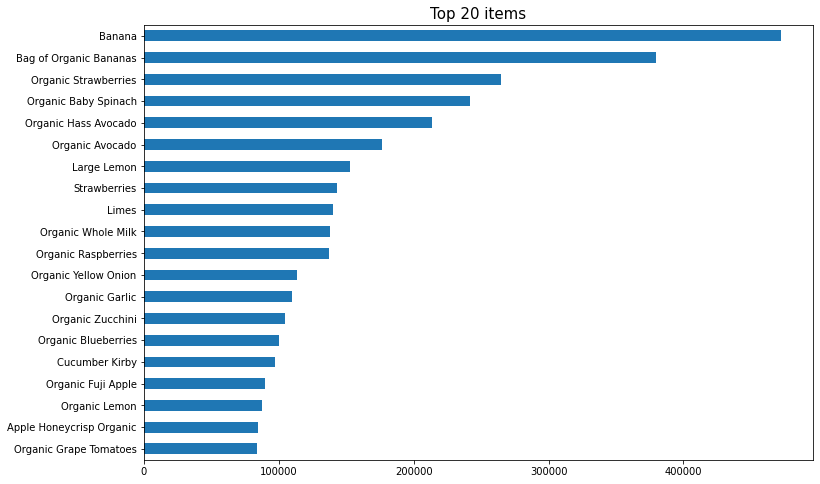

In [ ]:
plt.figure(figsize=(12, 8))
priors.product_name.value_counts().head(20).sort_values().plot.barh()
plt.title('Top 20 items', fontsize=15)
plt.show()

 Top20 제품의 대부분이 과일, 채소 등 신선식품이며 판매량 1,2위 모두 바나나로 가장 많이 팔렸다. Oragnic 제품이 상위권에 많이 분포한 것을 알 수 있다.

## 제품별 재구매율


In [ ]:
data = priors.groupby('product_id')['reordered'].sum() / priors.product_id.value_counts()
data = data.sort_values(ascending=False)
data.describe()

count    49677.000000
mean         0.366461
std          0.208103
min          0.000000
25%          0.208075
50%          0.376623
75%          0.529307
max          0.941176
dtype: float64

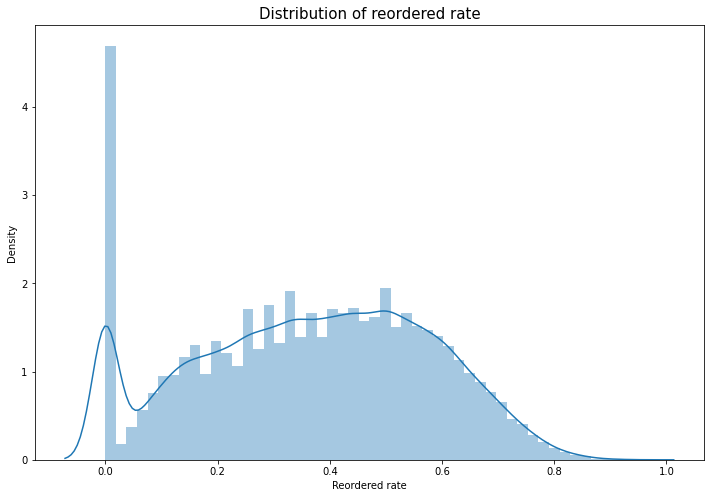

In [ ]:
plt.figure(figsize=(12, 8))
sns.distplot(data, kde=True)
plt.title('Distribution of reordered rate', fontsize=15)
plt.xlabel('Reordered rate')
plt.show()

# 4. Department



department에 정보 추가 (대분류별)

1. orders : 총 주문 수
2. reorders : 재주문 수
3. reorder_rate : 재주문 율
4. mean_cart_order : 평균 장바구니 순위

In [ ]:
# priors에서 피쳐뽑기

depart = pd.DataFrame()
# 총 주문 수
depart['orders'] = priors['department_id'].value_counts().sort_index()
# 재주문 수
depart['reorders'] = priors.groupby('department_id')['reordered'].sum()
# 재주문 율
depart['reorder_rate'] = (depart.reorders / depart.orders)
# 평균 장바구니 순위
depart['mean_cart_order'] = priors.groupby('department_id')['add_to_cart_order'].mean()
depart = depart.reset_index().rename(columns={'index':'department_id'})
memory_reduce(depart)

Before : 0.00 MB
정수형 데이터 Before : 0.00 MB -> After : 0.00 MB
실수형 데이터 Before : 0.00 MB -> After : 0.00 MB
문자열 데이터 Before : 0.00 MB -> After : 0.00 MB
After : 0.00 MB



,department_id,orders,reorders,reorder_rate,mean_cart_order
0,1,2236432,1211890.0,0.541885,8.996414
1,2,36291,14806.0,0.407980,8.277644
2,3,1176787,739188.0,0.628141,8.084396
3,4,9479291,6160710.0,0.649913,8.022875
4,5,153696,87595.0,0.569924,5.428346
5,6,269253,99416.0,0.369229,9.947061
6,7,2690129,1757892.0,0.653460,6.976699
7,8,97724,58760.0,0.601285,7.718544
8,9,866627,399581.0,0.461076,10.212863
9,10,34573,19950.0,0.577040,8.399039


In [ ]:
# 생성한 피쳐 추가

departments = pd.merge(departments, depart)
del depart
departments['reorders'] = departments['reorders'].astype(np.uint32)
departments.head()

,department_id,department,orders,reorders,reorder_rate,mean_cart_order
0,1,frozen,2236432,1211890,0.541885,8.996414
1,2,other,36291,14806,0.407980,8.277644
2,3,bakery,1176787,739188,0.628141,8.084396
3,4,produce,9479291,6160710,0.649913,8.022875
4,5,alcohol,153696,87595,0.569924,5.428346


## 가장 많이 팔린 순서

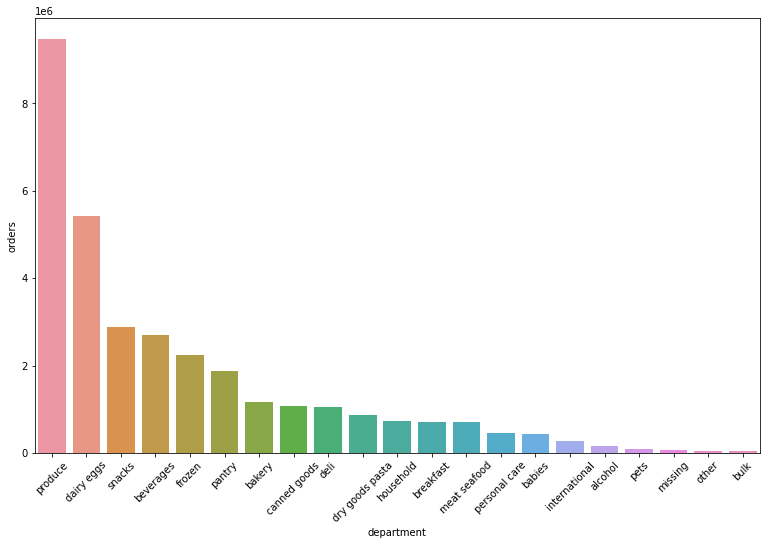

In [ ]:
plt.figure(figsize=(13, 8))
sns.barplot(x='department', y='orders', data=departments.sort_values(by='orders', ascending=False))
plt.xticks(rotation=45)
plt.show()

농작물과 유제품&달걀류가 가장 많이 팔리는 것을 확인할 수 있다.

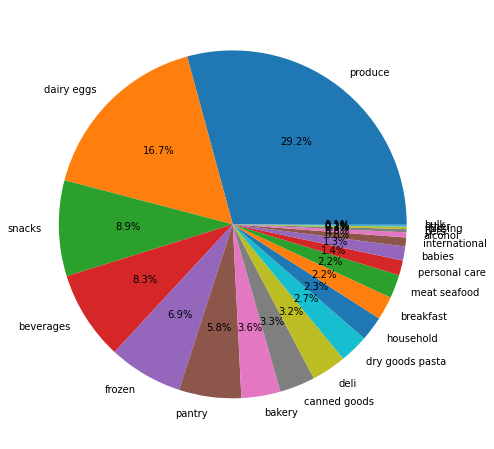

In [ ]:
data = departments.sort_values(by='orders', ascending=False)
plt.figure(figsize=(13, 8))
plt.pie(x=data.orders, labels=data.department, autopct='%.1f%%')
plt.xticks(rotation=45)
plt.show()

produce 카테고리가 전체 상품 중 29.2를 차지한다. 그 다음 유제품 & 달걀이 많이 팔렸다.

## 재주문율

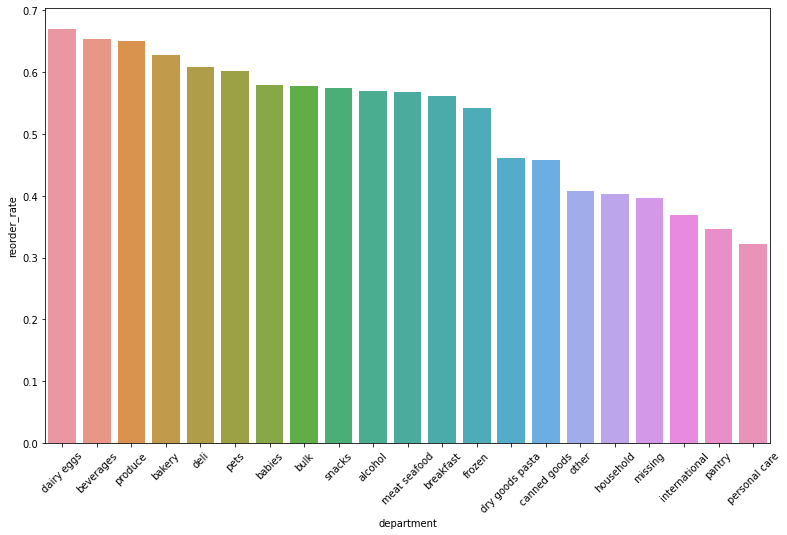

In [ ]:
plt.figure(figsize=(13, 8))
sns.barplot(x='department', y='reorder_rate', data=departments.sort_values(by='reorder_rate', ascending=False))
plt.xticks(rotation=45)
plt.show()

재주문율이 가장 높은 카테고리는 dairy eggs이다.

## 평균 장바구니 순위

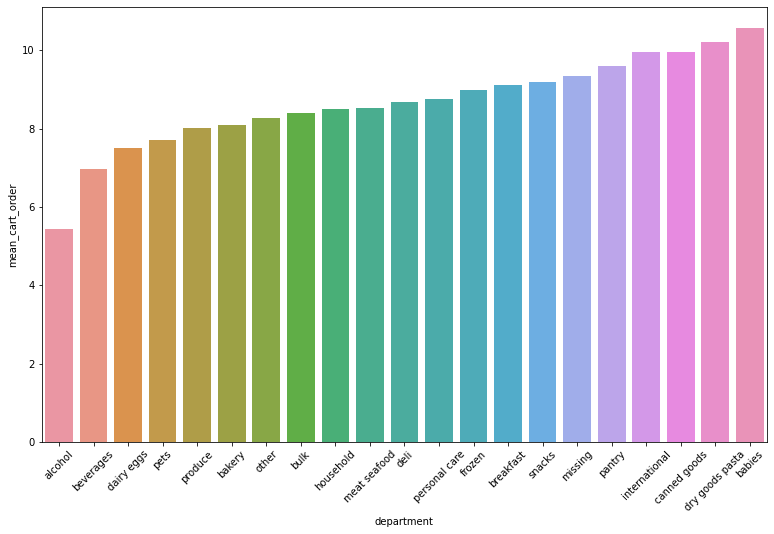

In [ ]:
plt.figure(figsize=(13, 8))
sns.barplot(x='department', y='mean_cart_order', data=departments.sort_values(by='mean_cart_order'))
plt.xticks(rotation=45)
plt.show()

장바구니에 가장 먼저 담긴 카테고리는 alcohol > beberages > dairy eggs 순서이다. add_to_cart_order에서 장바구니에 먼저 담긴 상품일수록 재구매율이 높아지는 경향을 확인했는데, 이부분과 연결하여 생각해볼 필요가 있어보인다.

# 5. aisle



aisle 정보 추가 (소분류별)

1. orders : 총 주문 수
2. reorders : 재주문 수
3. reorder_rate : 재주문 율
4. mean_cart_order : 평균 장바구니 순위

In [ ]:
ais = pd.DataFrame()
# 총 주문 수
ais['orders'] = priors['aisle_id'].value_counts().sort_index()
# 재주문 수
ais['reorders'] = priors.groupby('aisle_id')['reordered'].sum()
# 재주문 율
ais['reorder_rate'] = (ais.reorders / ais.orders)
# 평균 장바구니 순위
ais['mean_cart_order'] = priors.groupby('aisle_id')['add_to_cart_order'].mean()
ais = ais.reset_index().rename(columns={'index':'aisle_id'})
memory_reduce(ais)

Before : 0.01 MB
정수형 데이터 Before : 0.00 MB -> After : 0.00 MB
실수형 데이터 Before : 0.00 MB -> After : 0.00 MB
문자열 데이터 Before : 0.00 MB -> After : 0.00 MB
After : 0.00 MB



,aisle_id,orders,reorders,reorder_rate,mean_cart_order
0,1,71928,42912.0,0.596597,8.167640
1,2,82491,40365.0,0.489326,9.275496
2,3,456386,272922.0,0.598007,9.571935
3,4,200687,98243.0,0.489533,10.161450
4,5,62510,17542.0,0.280627,10.297601
...,...,...,...,...,...
129,130,158164,79003.0,0.499501,9.273887
130,131,266637,120803.0,0.453062,10.356121
131,132,6168,1308.0,0.212062,8.991083
132,133,18683,6410.0,0.343093,7.475941


In [ ]:
aisles = pd.merge(aisles, ais)
del ais
aisles.head()

,aisle_id,aisle,orders,reorders,reorder_rate,mean_cart_order
0,1,prepared soups salads,71928,42912.0,0.596597,8.167640
1,2,specialty cheeses,82491,40365.0,0.489326,9.275496
2,3,energy granola bars,456386,272922.0,0.598007,9.571935
3,4,instant foods,200687,98243.0,0.489533,10.161450
4,5,marinades meat preparation,62510,17542.0,0.280627,10.297601


## 가장 많이 팔린 순서 (Top 20)

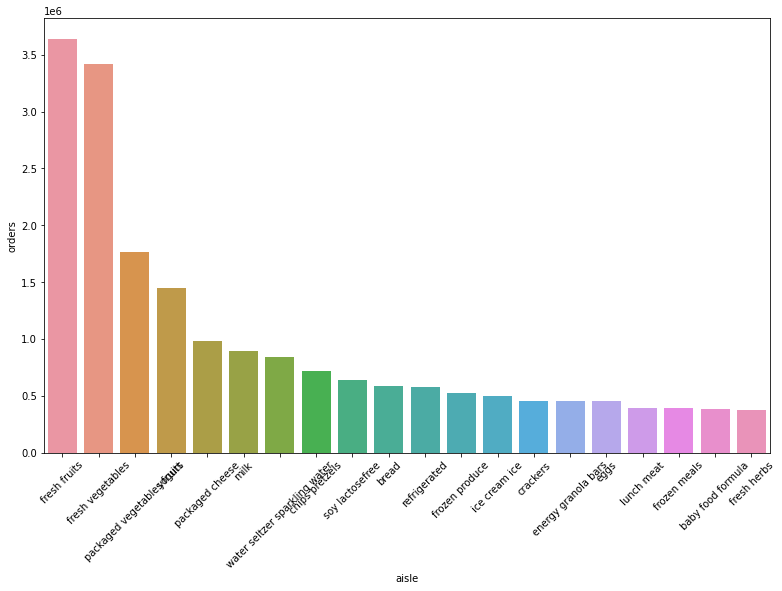

In [ ]:
plt.figure(figsize=(13, 8))
sns.barplot(x='aisle', y='orders', data=aisles.sort_values(by='orders', ascending=False).head(20))
plt.xticks(rotation=45)
plt.show()

위에서 본 것과 마찬가지로 과일, 야채 등 신선식품류가 가장 많이 판매됐다.

## 재주문율

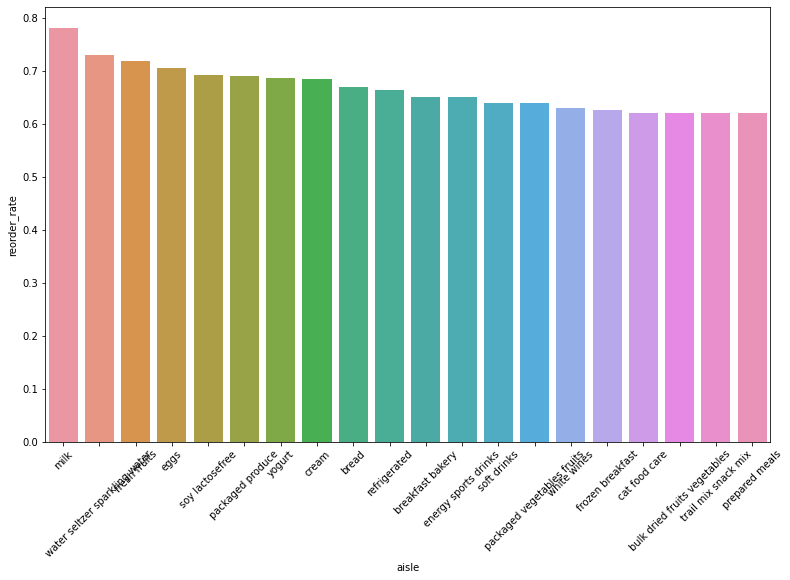

In [ ]:
plt.figure(figsize=(13, 8))
sns.barplot(x='aisle', y='reorder_rate', data=aisles.sort_values(by='reorder_rate', ascending=False).head(20))
plt.xticks(rotation=45)
plt.show()

milk가 가장 높은 재구매율을 보인다.

## 평균 장바구니 순위

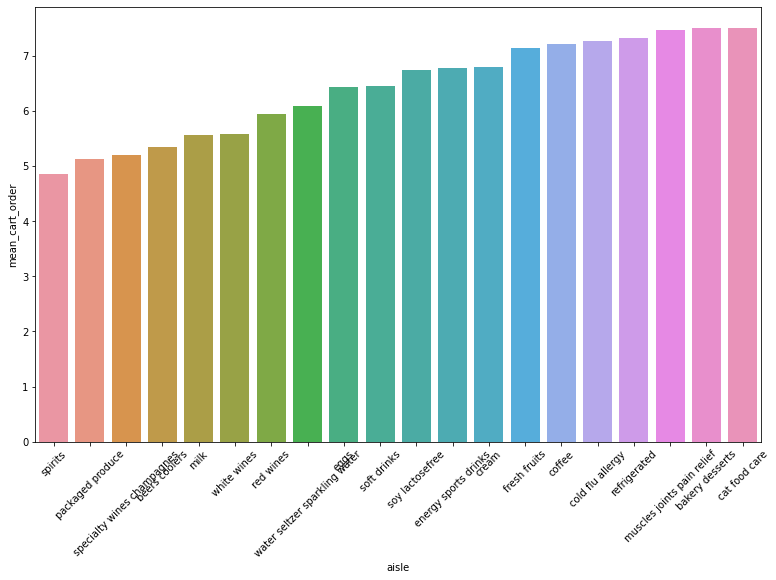

In [ ]:
plt.figure(figsize=(13, 8))
sns.barplot(x='aisle', y='mean_cart_order', data=aisles.sort_values(by='mean_cart_order').head(20))
plt.xticks(rotation=45)
plt.show()

평균 장바구니 순위는 aisle 기준에서도 술이 가장 먼저 담기는 것으로 나타났다.

# 6. ✅ Users



유저별 피쳐 생성

총 206,209 rows : 총 유저 인원 수와 같다. 

1. orders
    1. average_days_between_orders : 평균 재주문 기간 
    2. nb_orders : 총 주문 횟수
2. priors

    1. total_items : 총 구매 상품수
    2. all_products : 총 구매 상품 품목
    3. total_distinct_items : 총 구매 상품 품목 수
3. average_basket : 주문 당 평균 상품 수

또 추가 해볼 것 : 유저가 구매한 모든 제품의 소분류와 대분류


## ✅ priors에 orders 추가

유저 정보를 포함하게 되었다.

In [ ]:
priors = pd.merge(priors, orders)
priors.drop('eval_set', axis=1, inplace=True)
priors.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32434489 entries, 0 to 32434488
Data columns (total 14 columns):
 #   Column                  Dtype   
---  ------                  -----   
 0   order_id                uint32  
 1   product_id              uint16  
 2   add_to_cart_order       uint8   
 3   reordered               uint8   
 4   product_name            category
 5   aisle_id                uint8   
 6   aisle                   category
 7   department_id           uint8   
 8   department              category
 9   user_id                 uint32  
 10  order_number            uint8   
 11  order_dow               uint8   
 12  order_hour_of_day       uint8   
 13  days_since_prior_order  float32 
dtypes: category(3), float32(1), uint16(1), uint32(2), uint8(7)
memory usage: 1.1 GB


In [ ]:
priors.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,aisle,department_id,department,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,eggs,16,dairy eggs,202279,3,5,9,8.0
1,2,45918,4,1,Coconut Butter,19,oils vinegars,13,pantry,202279,3,5,9,8.0
2,2,30035,5,0,Natural Sweetener,17,baking ingredients,13,pantry,202279,3,5,9,8.0
3,2,17794,6,1,Carrots,83,fresh vegetables,4,produce,202279,3,5,9,8.0
4,2,9327,3,0,Garlic Powder,104,spices seasonings,13,pantry,202279,3,5,9,8.0


In [ ]:
# 유저별 정보 추가 (orders)
usr = pd.DataFrame()
# 평균 재주문 기간
usr['average_days_between_orders'] = orders.groupby('user_id')['days_since_prior_order'].mean()
# 총 주문 횟수
usr['nb_orders'] = orders.groupby('user_id').size()

# 유저별 정보 추가 (df)
users = pd.DataFrame()
# 총 구매 상품 수
users['total_items'] = priors.groupby('user_id').size()
# 총 구매 상품 종류(중복 제거)
users['all_products'] = priors.groupby('user_id')['product_id'].apply(set)
# 총 구매 상품 품목 수
users['total_distinct_items'] = (users['all_products'].map(len))

users = users.join(usr)
del usr

# 주문당 평균 상품 수
users['average_basket'] = (users['total_items'] / users['nb_orders'])

int_memory_reduce(users)
float_memory_reduce(users).head()

Before : 14.36 MB -> After : 10.62 MB
Before : 11.21 MB -> After : 10.42 MB


,total_items,all_products,total_distinct_items,average_days_between_orders,nb_orders,average_basket
user_id,,,,,,
1,59,"{17122, 196, 26405, 46149, 14084, 13032, 26088...",18,19.000000,11,5.363636
2,195,"{45066, 2573, 18961, 23, 32792, 1559, 22559, 1...",102,16.285715,15,13.000000
3,88,"{17668, 44683, 48523, 21903, 14992, 21137, 324...",33,12.000000,13,6.769231
4,18,"{21573, 42329, 17769, 35469, 37646, 1200, 1905...",17,17.000000,6,3.000000
5,37,"{11777, 40706, 28289, 48775, 20754, 6808, 1398...",23,11.500000,5,7.400000


In [ ]:
users.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 206209 entries, 1 to 206209
Data columns (total 6 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   total_items                  206209 non-null  uint16 
 1   all_products                 206209 non-null  object 
 2   total_distinct_items         206209 non-null  uint16 
 3   average_days_between_orders  206209 non-null  float32
 4   nb_orders                    206209 non-null  uint8  
 5   average_basket               206209 non-null  float32
dtypes: float32(2), object(1), uint16(2), uint8(1)
memory usage: 13.8+ MB


# 7. ✅ User_produtcs_priors 





유저별로 해당 유저가 구매한 모든 제품을 1:1로 매칭 시켜서 새로운 데이터 프레임을 뽑아낸다. 

priors (제품의 모든 구매 내역)을 가져와서 가공한다. priors에는 주문 별로 구매된 제품을 1:1로 매칭 시켜서 총 32,434,489만 개의 행이 있다.

이것을 유저 별로 구매한 제품과 매칭 시킨다. user_id와 product_id를 합쳐서 하나의 컬럼으로 만들고 groupby하면 유저별로 구매한 모든 제품을 중복없이 처리할 수 있다. 

유저와 유저가 구매한 제품을 매칭해서 중복을 제거하면 총 13,307,953개의 행이 된다.

컬럼은 총 3개.

1. nb_orders : 해당 유저가 해당 제품을 몇 번 구매했는지.
2. last_order_id : 해당 유저가 해당 제품을 주문한 마지막 order_id
3. sum_pos_in_cart : 해당 유저가 해당 제품을 구매하면서 누적된 장바구니 우선순위 
4. everage_pos_in_cart : 평균 장바구니 우선순위

In [ ]:
user_products = priors.copy()
user_products.drop(['aisle_id','department_id','order_number','order_dow','order_hour_of_day','days_since_prior_order'], axis=1, inplace=True)
user_products['user_product'] =  user_products['product_id'] + user_products['user_id'].astype(np.uint64) * 100000 
# user_id 뒤에 1만 자리수를 만들어서 product_id를 이어 붙인다. 
user_products = user_products.groupby('user_product').agg({'order_id' : ['size', 'last'], 
                                                           'add_to_cart_order': 'sum'})
# 중복 제거를 위해 user_product로 groupby한다. 
user_products.columns = ['nb_orders', 'last_order_id', 'sum_pos_in_cart']
user_products['sum_pos_in_cart'] = user_products['sum_pos_in_cart'].astype(np.uint16)
user_products['everage_pos_in_cart'] = (user_products.sum_pos_in_cart / user_products.nb_orders).astype(np.float32)
memory_reduce(user_products).head()

Before : 329.98 MB
정수형 데이터 Before : 203.06 MB -> After : 114.22 MB
실수형 데이터 Before : 101.53 MB -> After : 101.53 MB
문자열 데이터 Before : 101.53 MB -> After : 0.00 MB
After : 241.14 MB



,nb_orders,last_order_id,sum_pos_in_cart,everage_pos_in_cart
user_product,,,,
100196,10,3367565,14,1.400000
110258,9,3367565,30,3.333333
110326,1,431534,5,5.000000
112427,10,3367565,33,3.300000
113032,3,2550362,19,6.333333


In [ ]:
user_products.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 13307953 entries, 100196 to 20620948742
Data columns (total 4 columns):
 #   Column               Dtype  
---  ------               -----  
 0   nb_orders            uint8  
 1   last_order_id        uint32 
 2   sum_pos_in_cart      uint16 
 3   everage_pos_in_cart  float32
dtypes: float32(1), uint16(1), uint32(1), uint8(1)
memory usage: 241.1 MB


# 2. Feature engineering

타겟과 피쳐를 비교할 수 있게, 그리고 데이터를 모델에 넣을 수 있게 데이터를 재가공한다. 


1. orders에서 eval_set이 train인 데이터만 order_train으로 뽑아낸다. 
2. order_train에 포함된 user가 구매한 모든 제품을 가지고 (order_id, user_id)와 매칭 시켜서 데이터 프레임을 부풀린다. 
3. 위에서 생성한 피쳐를 합치고, 새로운 피쳐를 생성해서 추가한다.


## 1. order_train 생성

orders에서 eval_set이 train인 데이터만 order_train으로 뽑아낸다.

In [ ]:
order_train = orders[orders['eval_set'] == 'train'].reset_index(drop=True)
order_train

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,1187899,1,train,11,4,8,14.0
1,1492625,2,train,15,1,11,30.0
2,2196797,5,train,5,0,11,6.0
3,525192,7,train,21,2,11,6.0
4,880375,8,train,4,1,14,10.0
...,...,...,...,...,...,...,...
131204,2585586,206199,train,20,2,16,30.0
131205,943915,206200,train,24,6,19,6.0
131206,2371631,206203,train,6,4,19,30.0
131207,1716008,206205,train,4,1,16,10.0


## 2. train_df 생성

order_train에 포함된 user가 구매한 모든 제품을 가지고 (order_id, user_id)와 매칭 시켜서 데이터 프레임을 부풀린다. 

총 8,474,661 개의 행을 가진 데이터프레임 생성. 훈련셋에 포함된 고객이 구매한 총 제품수이다.

In [ ]:
# 데이터 프레임 재구성
train_user_id = order_train['user_id'].values     # 훈련 셋 유저 배열 
train_order_id = order_train['order_id'].values   # 훈련 셋 주문 배열
products_len = users['total_distinct_items'][train_user_id].values   # 훈련 셋에 있는 고객이 구매한 모든 제품의 수 배열

# 훈련 셋에 있는 고객이 구매한 모든 제품을 하나의 넘파이 배열로 생성하기
products_list = users['all_products'][train_user_id].apply(list).apply(np.array).values
products_list = np.concatenate(products_list)
print(f"훈련 셋에 있는 고객이 구매한 모든 제품의 수 : {products_list.shape}")

# products_list 만큼 order_id의 수를 늘리기. products_len을 이용해서 유저가 구매한 제품의 수만큼 order_id를 복제한다.
orders_list = np.repeat(train_order_id, products_len)
print(f"order_id의 수 : {orders_list.shape}")

train_df = pd.DataFrame({'order_id':orders_list, 'product_id':products_list}).sort_values(by='order_id').reset_index(drop=True)
train_df

훈련 셋에 있는 고객이 구매한 모든 제품의 수 : (8474661,)
order_id의 수 : (8474661,)


,order_id,product_id
0,1,44632
1,1,49302
2,1,2067
3,1,24852
4,1,22035
...,...,...
8474656,3421070,17902
8474657,3421070,35951
8474658,3421070,16953
8474659,3421070,31506


## 3. 타겟 생성

우리는 훈련셋에 포함된 유저가 구매했던 모든 데이터를 가지고 데이터 프레임을 만들었다. 그리고 우리는 `order_products_train`데이터를 확인해서 고객이 구매한 모든 데이터중 고객이 실제로 구매한 데이터가 무엇인지 알 수 있다. 
해당 제품을 고객이 구매했다면 1, 아니면 0으로 타겟 컬럼을 생성한다.

### train 데이터 로드

In [ ]:
train = pd.read_csv(PATH + 'order_products__train.csv', dtype={
            'order_id': np.uint32,          # 1 ~ 3421083
            'product_id': np.uint16,        # 1 ~ 49688
            'add_to_cart_order': np.uint8,   # 1 ~ 80
            'reordered': np.uint8})         # 0 ~ 1

In [ ]:
train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [ ]:
# 실제로 구매한 데이터
target_set = set(train.set_index(['order_id','product_id'], drop=False).index)
# 위에서 생성한 데이터
compare_list = train_df.values
# 두 데이터를 비교해서 타겟 생성
target = [(order_id, product_id) in target_set for order_id, product_id in compare_list]

# 데이터 프레임에 병합
train_df['target'] = target
train_df['target'] = train_df['target'].astype(np.uint8)
del target_set, compare_list, target
train_df

,order_id,product_id,target
0,1,44632,0
1,1,49302,1
2,1,2067,0
3,1,24852,0
4,1,22035,1
...,...,...,...
8474656,3421070,17902,0
8474657,3421070,35951,1
8474658,3421070,16953,1
8474659,3421070,31506,0


## 4. 피쳐 추가

**먼저 user_id와  user_product 추가**

train과 test 데이터에 공통적으로 적용할 수 있는 피쳐만 사용해야 한다.

- **orders** : order_id에 맞춰서 병합

    - order_dow : 주문 요일
    - order_hour_of_day : 주문 시간
    - days_since_prior_order : 이전 주문과의 간격 (일). 최대 30일이다.

- **priors** : 피쳐를 그대로 사용할 수 없다. priors에 있는 피쳐는 해당 order와 product가 1:1로 매칭 된 것이기 때문이다. 가공한 products DF의 피쳐를 사용한다.

- **products** : product_id에 맞춰서 병합

    - orders : 총 팔린 수
    - reorders : 재주문 수
    - reorder_rate : 재주문 율
    - mean_cart_order : 평균 장바구니 순위
    - aisle_id : 소분류
    - department_id : 대분류

- **users** : user_id에 맞춰서 병합

    - average_days_between_orders : 평균 재주문 기간
    - nb_orders : 총 주문 횟수
    - total_items : 총 구매 상품수
    - total_distinct_items : 총 구매 상품 품목 수
    - average_basket : 주문 당 평균 상품 수

- **user_products_priors** : user_product에 맞춰서 병합

    - nb_orders : 해당 유저가 해당 제품을 몇 번 구매했는지.
    - last_order_id : 해당 유저가 해당 제품을 주문한 마지막 order_id
    - sum_pos_in_cart : 해당 유저가 해당 제품을 구매하면서 누적된 장바구니 우선순위
    - everage_pos_in_cart : 평균 장바구니 우선순위

    - **orders_ratio : 해당 유저의 전체 주문 중 이 제품이 포함된 주문의 비율 (생성)**
    - **orders_since_last : 해당 제품을 마지막으로 구매한 이후로 몇 번의 주문이 더 있었는지. 만약 이 수치가 크다면 이 제품을 구매하고 여러 번 더 주문 할 동안 이 제품은 더 이상 구매하지 않았다는 뜻. (생성)** 
    - **delta_hour_vs_last : 마지막 주문 시간(hod) 에서 해당 제품을 구매한 마지막 주문 시간의 차이를 확인. 너무 차이가 크다면 주기적으로 구매하는 제품은 아니라고 판단할 수도 있다. (생성)**

### user

In [ ]:
pd.merge(train_df, order_train[['order_id','user_id']])

,order_id,product_id,target,user_id
0,1,44632,0,112108
1,1,49302,1,112108
2,1,2067,0,112108
3,1,24852,0,112108
4,1,22035,1,112108
...,...,...,...,...
8474656,3421070,17902,0,139822
8474657,3421070,35951,1,139822
8474658,3421070,16953,1,139822
8474659,3421070,31506,0,139822


In [ ]:
sample_submission

,order_id,products
0,17,39276 29259
1,34,39276 29259
2,137,39276 29259
3,182,39276 29259
4,257,39276 29259
...,...,...
74995,3420740,39276 29259
74996,3420877,39276 29259
74997,3420888,39276 29259
74998,3420989,39276 29259


## 5. 상관 관계 분석

# 3. 베이스 라인 모델

**모델** : 일단 XGBoost, LGBM, LF를 사용해본다. (앙상블?)

**평가 지표** : F1score 
- F1 score 함수 생성

**CV** : how? 찾아보기

In [ ]:
# 검증을 위한 매트릭스 함수

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    print("정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}".format(accuracy, precision, recall, f1, roc_auc))

# 4. 성능 개선



1. 피쳐 스케일링
2. 피쳐 생성, 제거
3. 인코딩

## 모델 훈련/예측/평가


1. GridSearchCV
2. 예측
3. 평가



# Submit

### 예측 결과를 submit 형식에 맞게 변경하고 csv로 저장

In [ ]:
TRESHOLD = 0.22

d = dict()
for row in X_test.itertuples():
    if row.pred > TRESHOLD:
        try:
            d[row.order_id] += ' ' + str(row.product_id)
        except:
            d[row.order_id] = str(row.product_id)

for order in test_orders.order_id:
    if order not in d:
        d[order] = 'None'

sub = pd.DataFrame.from_dict(d, orient='index')

sub.reset_index(inplace=True)
sub.columns = ['order_id', 'products']
sub.to_csv('sub.csv', index=False)

### 캐글 API 키를 사용해서 바로 submit하기

In [ ]:
# 캐글 API 키 설정 사용하기
!mkdir -p ~/.kaggle
%cd /content/drive/MyDrive/
!chmod 600 kaggle.json
!cp kaggle.json ~/.kaggle
%cd /content

# submit코드
!kaggle competitions submit -c instacart-market-basket-analysis -f sub.csv -m "2"